### PyTorchを使ってLSTMでコロナ陽性者数を予測


### データセット
日毎のPCR検査結果が陽性の人の数、東京の平均気温、PCR検査実施人数 (要加工)

参考: https://qiita.com/tsubauaaa/items/8411a22465811ec2ee11

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [36]:
# deviceの作成
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [37]:
device

'cuda'

In [38]:
# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/lstm/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/lstm


In [39]:
# PCR陽性者数データ
# 厚生労働省オープンデータを利用
# https://www.mhlw.go.jp/stf/covid-19/open-data.html
data1 = pd.read_csv('/content/drive/My Drive/lstm/pcr_positive_daily.csv', encoding='shift_jis')
# 東京都の平均気温データ
# 気象庁のデータを利用
# https://www.data.jma.go.jp/gmd/risk/obsdl/#
data2 = pd.read_csv('/content/drive/My Drive/lstm/covid19_temperature.csv', encoding='shift_jis')
# PCR検査実施人数データ
# 厚生労働省オープンデータを利用
# https://www.mhlw.go.jp/stf/covid-19/open-data.html
data3 = pd.read_csv('/content/drive/My Drive/lstm/pcr_tested_daily.csv', encoding='utf-8').fillna(0)

In [40]:
# 3つのデータを結合
data4 = pd.merge(data1,data2, on='日付') # '日付' 列をキーとしてマージ
data = pd.merge(data4, data3, on='日付') # '日付' 列をキーとしてマージ

In [41]:
print(data.columns)
print(data.shape)
print(data.head(5))
print(data.tail(5))

Index(['日付', 'PCR 検査陽性者数(単日)', '東京平均気温', 'PCR 検査実施人数(単日)'], dtype='object')
(320, 4)
          日付  PCR 検査陽性者数(単日)  東京平均気温  PCR 検査実施人数(単日)
0  2020/1/16               1     6.7             0.0
1  2020/1/17               0     7.3             0.0
2  2020/1/18               0     3.8             0.0
3  2020/1/19               0     6.5             0.0
4  2020/1/20               0     7.5             0.0
             日付  PCR 検査陽性者数(単日)  東京平均気温  PCR 検査実施人数(単日)
315  2020/11/26            2494    12.8         42634.0
316  2020/11/27            2510    11.6         43351.0
317  2020/11/28            2667    11.8         22307.0
318  2020/11/29            2046    10.1         11975.0
319  2020/11/30            1425     9.9         41335.0


In [42]:
len_data = data.shape[0]

In [43]:
covid19_data = data[['PCR 検査陽性者数(単日)', '東京平均気温', 'PCR 検査実施人数(単日)']]

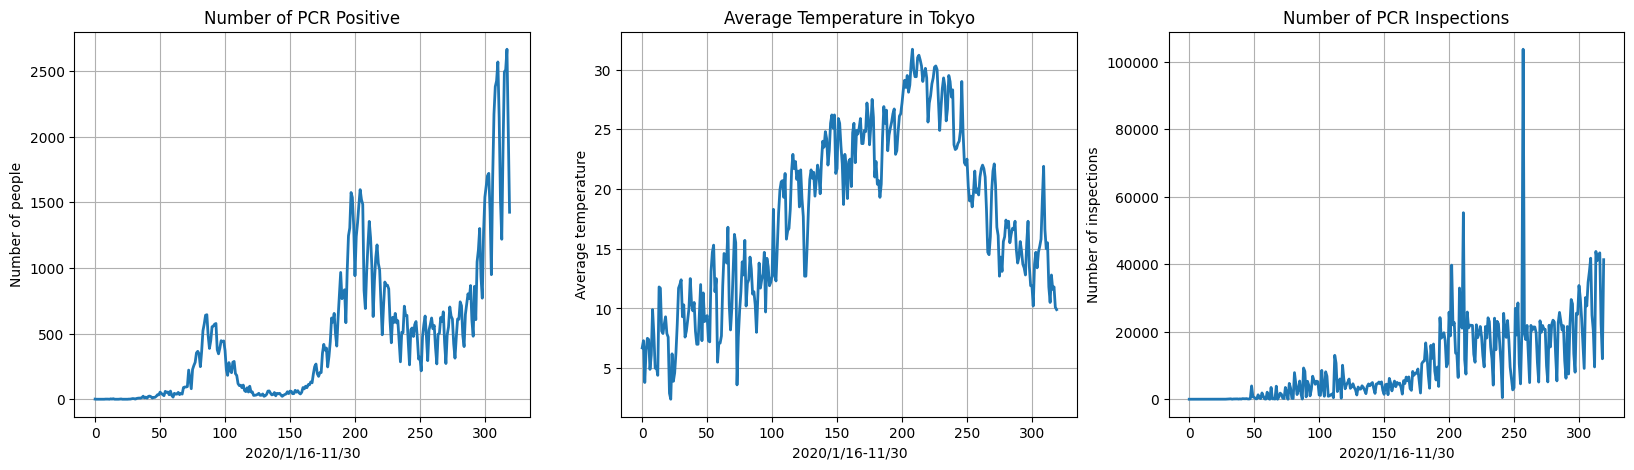

In [44]:
fig, (axL, axM, axR) = plt.subplots(ncols=3, figsize=(20,5))

axL.plot(covid19_data['PCR 検査陽性者数(単日)'], linewidth=2)
axL.set_title('Number of PCR Positive')
axL.set_xlabel('2020/1/16-11/30')
axL.set_ylabel('Number of people')
axL.grid(True)

axM.plot(covid19_data['東京平均気温'], linewidth=2)
axM.set_title('Average Temperature in Tokyo')
axM.set_xlabel('2020/1/16-11/30')
axM.set_ylabel('Average temperature')
axM.grid(True)

axR.plot(covid19_data['PCR 検査実施人数(単日)'], linewidth=2)
axR.set_title('Number of PCR Inspections')
axR.set_xlabel('2020/1/16-11/30')
axR.set_ylabel('Number of inspections')
axR.grid(True)

fig.show()

In [45]:
covid19_data = covid19_data.values.astype(float)

In [46]:
covid19_data.shape

(320, 3)

In [47]:
# 直近30日をテストデータにする
test_data_size = 30

train_data = covid19_data[:-test_data_size]
test_data = covid19_data[-test_data_size:]

In [48]:
print(len(train_data))
print(len(test_data))

290
30


In [49]:
# データセットの正規化 (最小値0と最大値1の範囲)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

In [50]:
# (バッチ数, (陽性者数, 平均気温))
train_data_normalized.shape

(290, 3)

In [51]:
# Tensor型に変換
train_data_normalized = torch.FloatTensor(train_data_normalized)

In [52]:
# シーケンスに沿ったデータを作成する関数
def make_sequence_data(input_data, num_sequence):
    # シーケンスデータとラベルデータの器
    data = []
    # 全体のデータ数取得
    num_data = len(input_data)
    # 全体からシーケンス分引いた数までループ
    for i in range(num_data - num_sequence):
        # 1個ずらして、シーケンス分のデータを取得
        seq_data = input_data[i:i+num_sequence]
        # シーケンスの次の要素のデータ(ラベルデータとして1個目の陽性者数のみ)を取得
        target_data = input_data[:,0][i+num_sequence:i+num_sequence+1]
        # シーケンスデータとラベルデータをタプルとして取得
        data.append((seq_data, target_data))

    return data

In [53]:
# シーケンス長は1ヶ月分30日
seq_length = 30
# train_seq_data=最初のデータを1個ずらしてシーケンス分のデータ(時系列の学習データ群)、train_target=train_seq_dataの次のデータ(ラベルデータ)
train_seq_data = make_sequence_data(train_data_normalized, seq_length)

In [54]:
# シーケンス分の1セットと正解データが260セット
print(len(train_seq_data))

260


In [55]:
class LSTM(nn.Module):
    def __init__(self, input_size=3, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)

    def forward(self, x):
        # LSTMのinputは(batch_size, seq_len, input_size)
        # LSTMのoutputは(batch_size, seq_len, hidden_layer_size)
        # hidden stateとcell stateにはNoneを渡して0ベクトルを渡す
        lstm_out, (hn, cn) = self.lstm(x, None)
        # Linearのinputは(N,∗,in_features)
        # lstm_out(batch_size, seq_len, hidden_layer_size)のseq_len方向の最後の値をLinearに入力
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction

In [56]:
model = LSTM()
model.to(device)

LSTM(
  (lstm): LSTM(3, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [57]:
# 損失関数と最適化関数を定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
epochs = 50
losses = []
for i in range(epochs):
    for seq, labels in train_seq_data:
        # seq, labelsのshapeは(seq_length, 特徴量)なのでLSTMに渡すために(batch, seq_length, 特徴量)にする。(batch=1)
        seq, labels = torch.unsqueeze(seq, 0), torch.unsqueeze(labels, 0)
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    losses.append(single_loss.item())
    print(f'epoch: {i}, loss : {single_loss.item()}')

epoch: 0, loss : 0.029085997492074966
epoch: 1, loss : 0.03889148309826851
epoch: 2, loss : 0.039580922573804855
epoch: 3, loss : 0.0364636592566967
epoch: 4, loss : 0.03174906224012375
epoch: 5, loss : 0.027431346476078033
epoch: 6, loss : 0.02406902424991131
epoch: 7, loss : 0.02145855315029621
epoch: 8, loss : 0.01983332633972168
epoch: 9, loss : 0.01889193244278431
epoch: 10, loss : 0.018348464742302895
epoch: 11, loss : 0.018034078180789948
epoch: 12, loss : 0.017848623916506767
epoch: 13, loss : 0.017857687547802925
epoch: 14, loss : 0.017811503261327744
epoch: 15, loss : 0.017969509586691856
epoch: 16, loss : 0.017111761495471
epoch: 17, loss : 0.017194734886288643
epoch: 18, loss : 0.0169677734375
epoch: 19, loss : 0.015817569568753242
epoch: 20, loss : 0.015112830325961113
epoch: 21, loss : 0.014732055366039276
epoch: 22, loss : 0.01508011668920517
epoch: 23, loss : 0.0145330298691988
epoch: 24, loss : 0.014942837879061699
epoch: 25, loss : 0.014437912963330746
epoch: 26, loss

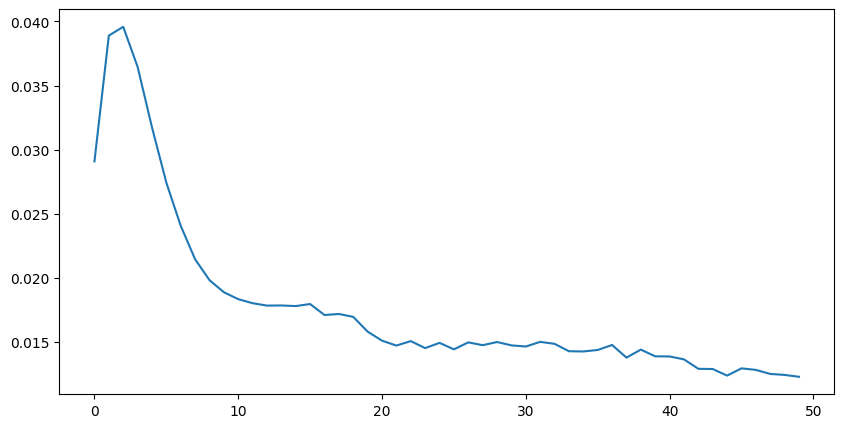

In [59]:
plt.plot(losses)

In [60]:
# # モデルパラメータを保存
# torch.save(model.state_dict(), './param.dict')

In [61]:
# # モデルパラメータをロード
# model.load_state_dict(torch.load('./param.dict'))

In [62]:
# 予測する日数
pred_days = 30
# テストデータの正規化を行う。最小値0と最大値1の範囲で行ってTensor型に変換
test_data_normalized = scaler.fit_transform(test_data)
test_data_normalized = torch.FloatTensor(test_data_normalized)
# 予測するためのデータの最初のseq_length分はtrain_dataを使う
test_inputs = train_data_normalized[-seq_length:].tolist()
print(test_inputs)

[[0.3362554907798767, 0.6348122954368591, 0.21084918081760406], [0.3519098162651062, 0.658703088760376, 0.13198812305927277], [0.2467125803232193, 0.6689419746398926, 0.04753269627690315], [0.1684408336877823, 0.658703088760376, 0.21089741587638855], [0.3099561631679535, 0.6348122954368591, 0.19710443913936615], [0.31433939933776855, 0.5426621437072754, 0.20642192661762238], [0.3901064395904541, 0.4197952151298523, 0.2063833475112915], [0.37194740772247314, 0.41296929121017456, 0.18998610973358154], [0.4170319437980652, 0.46416381001472473, 0.10419962555170059], [0.2698810398578644, 0.5938566327095032, 0.04896986857056618], [0.1703193485736847, 0.6518771052360535, 0.2241116613149643], [0.307451456785202, 0.6723549365997314, 0.19124966859817505], [0.3443957567214966, 0.6109215021133423, 0.21062733232975006], [0.4402003884315491, 0.49146756529808044, 0.20001736283302307], [0.3963681757450104, 0.467576801776886, 0.19967012107372284], [0.3825923502445221, 0.351535826921463, 0.0954512134194

In [63]:
# モデルを評価モードとする
model.eval()
# 予測値を入れるリスト
test_outputs = []
for i in range(pred_days):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    seq = torch.unsqueeze(seq, 0)
    seq = seq.to(device)
    with torch.no_grad():
        test_inputs.append(test_data_normalized.tolist()[i])
        test_outputs.append(model(seq).item())

In [64]:
print(len(test_outputs))

30


In [65]:
np_test_outputs = np.array(test_outputs).reshape(-1,1)
# 列方向に同じ値を追加して(30, 3)にする
np_test_outputs2 = np.hstack((np_test_outputs, np_test_outputs))
np_test_outputs3 = np.hstack((np_test_outputs2, np_test_outputs))
actual_predictions = scaler.inverse_transform(np_test_outputs3)

In [66]:
x = np.arange(len_data-pred_days, len_data, 1)
print(x)

[290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319]


In [67]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size

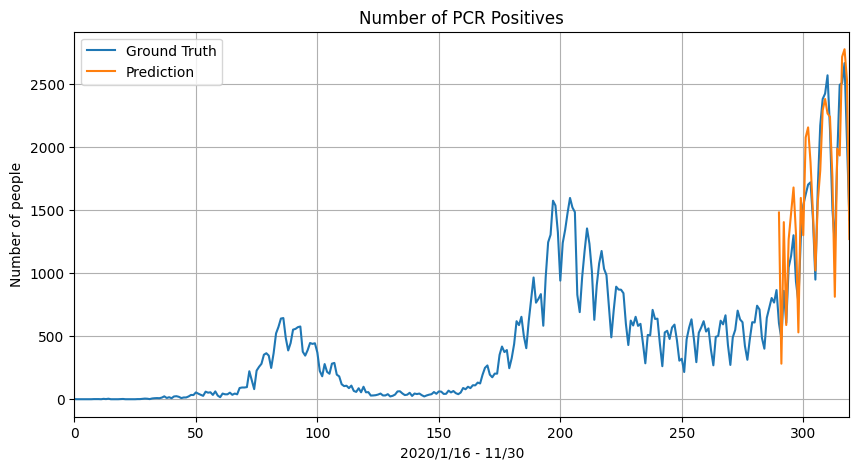

In [68]:
plt.title('Number of PCR Positives')
plt.ylabel('Number of people')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['PCR 検査陽性者数(単日)'], label='Ground Truth')
plt.plot(x, actual_predictions[:,0], label='Prediction')
plt.xlabel('2020/1/16 - 11/30')
plt.legend()
plt.show()

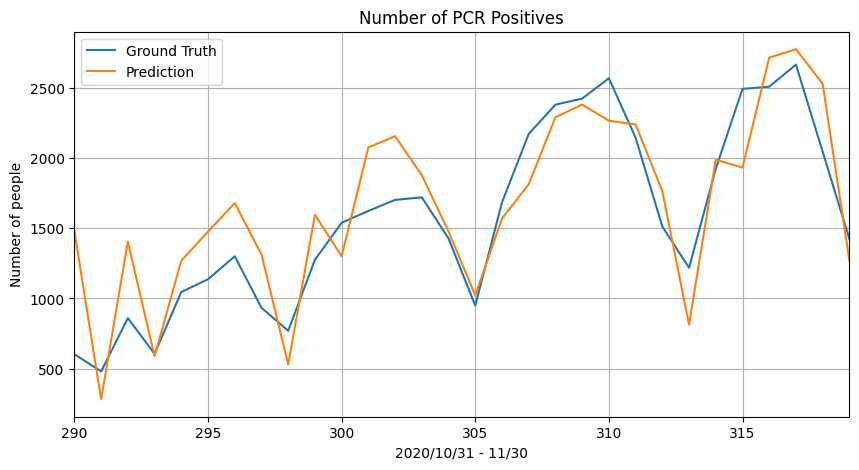

In [69]:
plt.title('Number of PCR Positives')
plt.ylabel('Number of people')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x, data['PCR 検査陽性者数(単日)'][-1*pred_days:], label='Ground Truth')
plt.plot(x, actual_predictions[:,0], label='Prediction')
plt.xlabel('2020/10/31 - 11/30')
plt.legend()
plt.show()